<a href="https://colab.research.google.com/github/Darkdew/Quora_QuestionPairs_Analysis_Project1/blob/master/Quora2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!pip install fuzzywuzzy
!pip install distance
!pip install wordcloud
!pip install pillow

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore") #setting warning filter to default value of ignore

import os
from os import path

from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup

from nltk.corpus import stopwords

from nltk.stem import PorterStemmer

from subprocess import check_output

from PIL import Image

from sklearn.manifold import t_sne

from wordcloud import WordCloud, STOPWORDS

import gc
import re
# This package is used to find the longest common subsequence between two strings
import distance

In [51]:
if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Quora_project1/df_fe_beforecleaning_train.csv'):
  df= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Quora_project1/df_fe_beforecleaning_train.csv', encoding= 'latin-1')
  df= df.fillna('')

else:
  print("run the previous notebook, your preprocessed file is not ready")

In [52]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


# Text-Preprocessing
### It will include:
- removing stopwords, punctuations, html tags
- expanding abbreviations or any contractions
- performing stemming



In [53]:
# To get the results in 4 decimal points
SAFE_DIV = 0.0001 

STOP_WORDS= stopwords.words("english")

def preprocessing(x):
  x= str(x).lower() #converting into string and then lowercase and then assigning back
  x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
  
  x = re.sub(r"([0-9]+)000000", r"\1m", x)
  x = re.sub(r"([0-9]+)000", r"\1k", x)

  porter= PorterStemmer()

  pattern= re.compile('\W') #searches for groups that have alphanumerics (that's the \w part) 
  #hence, breaks a line into words
  #the regular expression \W has been compiled for faster reuse

  if type(x)== type(''):
    x= re.sub(pattern, ' ', x)

  if type(x)== type(''):
    x= porter.stem(x)
    example1= BeautifulSoup(x)
    x= example1.get_text()

  return x




Advanced Feature_extraction

In [54]:
def get_token_adv_features(q1, q2):
  token_features= [0.0]*10

  #Tokenizing the sentences of each question
  q1_tokens= q1.split()
  q2_tokens= q2.split()

  if len(q1_tokens)==0 or len(q2_tokens)==0:
    return token_features

  #getting the non-stopwords in each of the questions
  q1_non_stopwords= set([word for word in q1_tokens if word not in STOP_WORDS])
  q2_non_stopwords= set([word for word in q2_tokens if word not in STOP_WORDS])

  #getting the stopwords in each of the questions:
  q1_stopwords= set([word for word in q1_tokens if word in STOP_WORDS])
  q2_stopwords= set([word for word in q2_tokens if word in STOP_WORDS])

  #getting the common stopwords from eac pair
  common_stopwords_count= len(q1_stopwords.intersection(q2_stopwords))
  
  #getting the common non-stop-words from each pair
  common_nonstopwords_count= len(q1_non_stopwords.intersection(q2_non_stopwords))

  #getting the common tokens from each of the Q's tokens
  common_tokens_count= len(set(q1_tokens).intersection(set(q2_tokens)))

  token_features[0]= common_nonstopwords_count / (min(len(q1_non_stopwords), len(q2_non_stopwords)) + SAFE_DIV)
  token_features[1]= common_nonstopwords_count / (max(len(q1_non_stopwords), len(q2_non_stopwords)) + SAFE_DIV)

  token_features[2]= common_stopwords_count / (min(len(q1_stopwords), len(q2_stopwords)) + SAFE_DIV)
  token_features[3]= common_stopwords_count / (max(len(q1_stopwords), len(q2_stopwords)) + SAFE_DIV)

  token_features[4]= common_tokens_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
  token_features[5]= common_tokens_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

  #checking if last word of the 2 questions is same
  token_features[6]= int(q1_tokens[-1]==q2_tokens[-1])

  #checking if first word of the 2 questions is same
  token_features[7]= int(q1_tokens[0]==q2_tokens[0])

  #calculating token length difference
  token_features[8]= abs(len(q1_tokens)- len(q2_tokens))

  #average of token-lengths of the pair
  token_features[9]= (len(q1_tokens)+ len(q2_tokens))/2

  return token_features

#getting the longest common substring ratio
#a distance.lcsubstrings function  can be used to find the longest common substrings in two sequences.
def get_longest_common_substring_ratio(a,b):
  strings= list(distance.lcsubstrings(a,b))
  if len(strings)==0:
    return 0
  else:
    return len(strings[0]) / (min(len(a) , len(b)) + 1)# why is 1 being added & why strings[0]

def extract_features(df):
  #preprocessing each question
  df["question1"]= df["question1"].fillna("").apply(preprocessing)
  df["question2"]= df["question2"].fillna("").apply(preprocessing)

  print ("Token Features:")

  #creating a new dataframe token_features and then merging its content with df
  token_features= df.apply(lambda x: get_token_adv_features(x["question1"], x["question2"]), axis=1)

  df["cwc_min"]       = list(map(lambda x: x[0], token_features))
  df["cwc_max"]       = list(map(lambda x: x[1], token_features))

  df["csc_min"]       = list(map(lambda x: x[2], token_features))
  df["csc_max"]       = list(map(lambda x: x[3], token_features))

  df["ctc_min"]       = list(map(lambda x: x[4], token_features))
  df["ctc_max"]       = list(map(lambda x: x[5], token_features))

  df["last_word_eq"]  = list(map(lambda x: x[6], token_features))

  df["first_word_eq"] = list(map(lambda x: x[7], token_features))

  df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))

  df["mean_len"]      = list(map(lambda x: x[9], token_features))

  #applying fuzzyfeatures technique
  print("fuzzy features:")
  df["fuzz_ratio"]        = df.apply(lambda x: fuzz.QRatio(x['question1'], ['question2']), axis=1)
  df["fuzz_partial_ratio"]= df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)
  df["token_set_ratio"]   = df.apply(lambda x: fuzz.token_set_ratio(x['question1'],x['question2']), axis=1)
  df["token_sort_ratio"]  = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis=1)

  df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_common_substring_ratio(x["question1"], x["question2"]), axis=1)

  return df

In [55]:
#Testing
#token_features1= [0.0]*10
#token_features1

In [56]:
if os.path.isfile('nlp_features_extracted-train.csv'):
  df= pd.read_csv('nlp_features_extracted-train.csv', encoding= 'latin-1')
  df.fillna('')
else:
  print("Extracting features for training")
  df= pd.read_csv("/content/drive/My Drive/Colab Notebooks/Quora_project1/Copy of train.csv")
  df= extract_features(df)
  df.to_csv("nlp_features_extracted-train.csv", index= False)

Extracting features for training
Token Features:
fuzzy features:


In [57]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_set_ratio,token_sort_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,16,100,100,93,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,20,75,86,63,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,15,47,63,63,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,10,14,28,24,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,7,56,67,47,0.175000


# Analysis of Extracted Features

- Plotting word clouds:

  - 1) creating wordClouds of duplicate and non-duplicate Question Pairs
  - 2)Identify most frequent words

In [59]:
df_duplicate= df[df['is_duplicate']==1]
df_nonduplicate = df[df['is_duplicate']==0]

dup_array   = np.dstack([df_duplicate['question1'], df_duplicate['question2']]).flatten()
nondup_array= np.dstack([df_nonduplicate['question1'], df_nonduplicate['question2']]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(dup_array))
print ("Number of data points in class 0 (non duplicate pairs) :",len(nondup_array))

#saving the above 2 arrays in a text file
np.savetxt('dup_array_train.txt', dup_array, delimiter= ' ', fmt= '%s')
np.savetxt('nondup_array_train.txt', nondup_array, delimiter= ' ', fmt= '%s')


Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [61]:
#removing the stopwords from the text files above

text_dup_words= open('/content/drive/My Drive/Colab Notebooks/Quora_project1/dup_array_train.txt').read()
text_nondup_words= open('/content/drive/My Drive/Colab Notebooks/Quora_project1/nondup_array_train.txt').read()

print("Total count of words in duplicate pairs text-collection= ", len(text_dup_words))
print("Total count of words from non-duplicate pairs text-collection= ", len(text_nondup_words))

stopwordss= set(STOPWORDS)
stopwordss.add("said")
stopwordss.add("br")
stopwordss.add(" ")
stopwordss.remove("no")
stopwordss.remove("not")
stopwordss.remove("like")



Total count of words in duplicate pairs text-collection=  16109886
Total count of words from non-duplicate pairs text-collection=  33193067


Word Cloud for Duplicate Question pairs


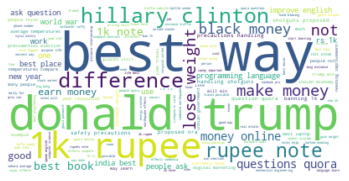

In [68]:
#Generating WordCloud with words from is_duplicate=1 question pairs collection

wc= WordCloud(background_color='white', max_words=len(text_dup_words), stopwords= stopwordss )
wc.generate(text_dup_words)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')

plt.axis('off')
plt.show

Word Cloud for non-Duplicate Question pairs


<function matplotlib.pyplot.show>

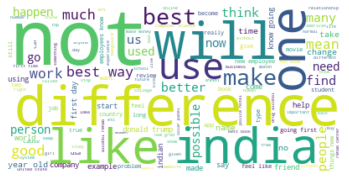

In [69]:
#Generating WordCloud with words from is_duplicate=0 question pairs collection

wc= WordCloud(background_color='white', max_words=len(text_nondup_words), stopwords= stopwordss )
wc.generate(text_nondup_words)
print ("Word Cloud for non-Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear') 

plt.axis('off')
plt.show

In [ ]:
#Learning# to access a particular location in a directory
#d = path.dirname('.') #. reps the home directory

#textp_w = open(path.join(d, 'train_p.txt')).read()

In [ ]:
#Learning# to draw pairplots
#n = df.shape[0]
#sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
#plt.show()

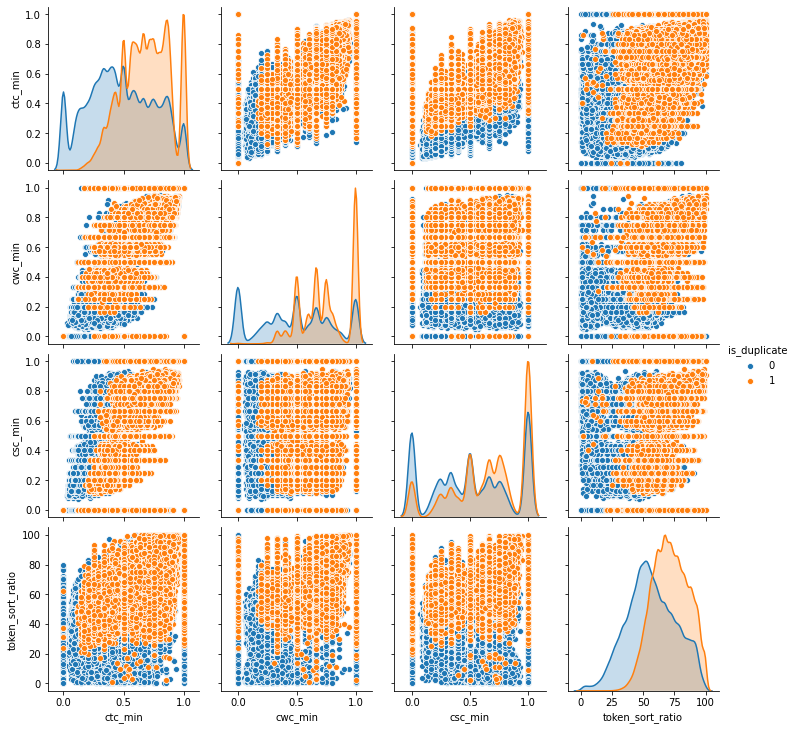

In [74]:
df1= df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']]

sns.pairplot(df1, hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])

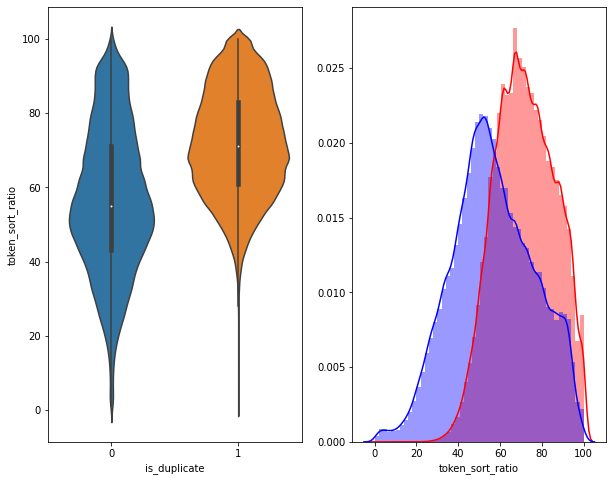

In [75]:
#distribution of the token_sort_ratio

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.violinplot(x= 'is_duplicate', y= 'token_sort_ratio', data=df)

plt.subplot(1,2,2)
df2= df[df['is_duplicate']==1.0]['token_sort_ratio']
df3= df[df['is_duplicate']==0.0]['token_sort_ratio']

sns.distplot(df2,  label= "1", color= 'red' )
sns.distplot(df3, label="0", color= 'blue')

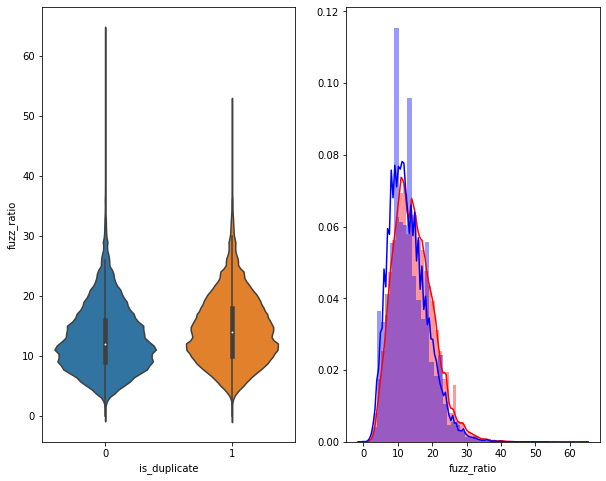

In [77]:
#distribution of the fuzz_ratio

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.violinplot(x= 'is_duplicate', y= 'fuzz_ratio', data=df[0:])

plt.subplot(1,2,2)
df2= df[df['is_duplicate']==1.0]['fuzz_ratio'][0:]
df3= df[df['is_duplicate']==0.0]['fuzz_ratio'][0:]

sns.distplot(df2,  label= "1", color= 'red' )
sns.distplot(df3, label="0", color= 'blue')

Visualization

In [78]:
# Using TSNE for Dimentionality reduction of 15 Features above to 3 dimention
#Scaling 
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', \
                                                 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , \
                                                 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , \
                                                 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' , \
                                                 'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [80]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.019s...
[t-SNE] Computed neighbors for 5000 samples in 0.378s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.138000
[t-SNE] Computed conditional probabilities in 0.298s
[t-SNE] Iteration 50: error = 81.9687042, gradient norm = 0.0508913 (50 iterations in 2.348s)
[t-SNE] Iteration 100: error = 71.1209869, gradient norm = 0.0092216 (50 iterations in 1.573s)
[t-SNE] Iteration 150: error = 69.4266510, gradient norm = 0.0065354 (50 iterations in 1.535s)
[t-SNE] Iteration 200: error = 68.7163162, gradient norm = 0.0048197 (50 iterations in 1.518s)
[t-SNE] Iteration 250: error = 68.2806015, gradient norm = 0.0033813

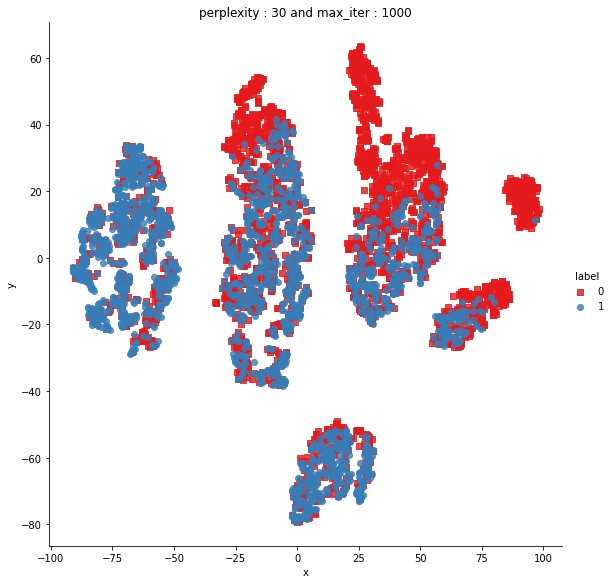

In [81]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [82]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.018s...
[t-SNE] Computed neighbors for 5000 samples in 0.368s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.138000
[t-SNE] Computed conditional probabilities in 0.290s
[t-SNE] Iteration 50: error = 80.6436615, gradient norm = 0.0312516 (50 iterations in 8.770s)
[t-SNE] Iteration 100: error = 69.7870255, gradient norm = 0.0032383 (50 iterations in 4.297s)
[t-SNE] Iteration 150: error = 68.5411224, gradient norm = 0.0018075 (50 iterations in 3.563s)
[t-SNE] Iteration 200: error = 67.9826660, gradient norm = 0.0012023 (50 iterations in 3.738s)
[t-SNE] Iteration 250: error = 67.6466675, gradient norm = 0.0008939

In [83]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')